# Training Baseline Model with Augmentation

In [2]:
# Importing necessary modules
import os
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

2024-08-10 19:40:23.531287: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 19:40:24.258446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-10 19:40:24.261607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 19:40:26.302055: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Loading data from custom module and defining image size
import data_loader

image_size = (224, 224)
train_ds, val_ds = data_loader.load_data()

Found 202 files belonging to 2 classes.
Using 162 files for training.
Using 40 files for validation.


In [4]:
# Applying data augmentation
train_ds, val_ds = data_loader.aug_data(train_ds, val_ds)

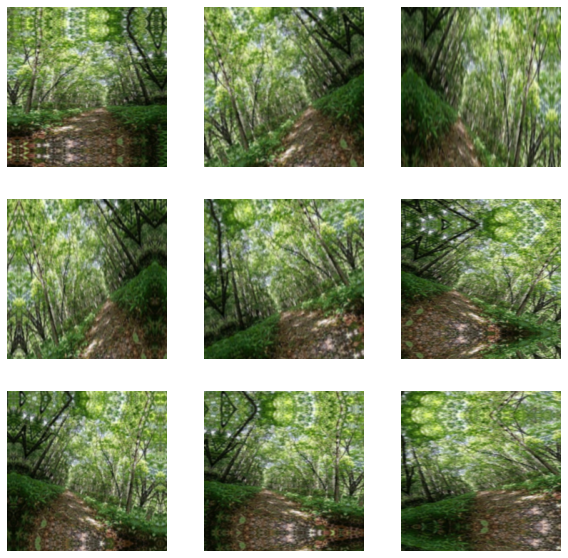

In [5]:
# Visualizing augmented data (function taken from dataloader.py module)
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(.5,.2)
    ]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [6]:
# Building a model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

        x = layers.SeparableConv2D(1024, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)

        x = layers.GlobalAveragePooling2D()(x)
        if num_classes == 2:
            units = 1
        else:
            units = num_classes

        x = layers.Dropout(0.25)(x)
        # We specify activation=None so as to return logits
        outputs = layers.Dense(units, activation=None)(x)
        return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [7]:
# Training the model
epochs = 8

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/8
17/17 [==============================] - 39s 2s/step - loss: 0.5319 - acc: 0.7284 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 2/8
17/17 [==============================] - 32s 2s/step - loss: 0.4258 - acc: 0.8210 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 3/8
17/17 [==============================] - 32s 2s/step - loss: 0.3941 - acc: 0.8519 - val_loss: 0.6919 - val_acc: 0.5000
Epoch 4/8
17/17 [==============================] - 33s 2s/step - loss: 0.4403 - acc: 0.8395 - val_loss: 0.6924 - val_acc: 0.5000
Epoch 5/8
17/17 [==============================] - 34s 2s/step - loss: 0.4180 - acc: 0.8272 - val_loss: 0.6926 - val_acc: 0.5000
Epoch 6/8
17/17 [==============================] - 32s 2s/step - loss: 0.4413 - acc: 0.7778 - val_loss: 0.6933 - val_acc: 0.5000
Epoch 7/8
17/17 [==============================] - 31s 2s/step - loss: 0.3852 - acc: 0.8580 - val_loss: 0.6947 - val_acc: 0.5000
Epoch 8/8
17/17 [==============================] - 35s 2s/step - loss: 0.4039 - acc: 0.8148 - val

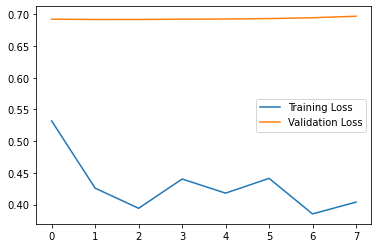

In [8]:
# Examining learning curves
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()

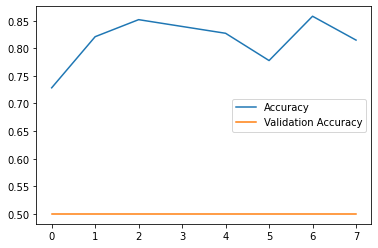

In [9]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()

In [10]:
# Saving second model with augmentation
model.save('base_model_aug.keras')